# Notebook for rereferencing, example with bipolar, CAR and iterable rereference (user defined number of channels).

Use STN-LFP data only, change upper rereference methods for LFP.
Estimate features, plot feature correlation matrix to see differences.
CAR - comon averaging rerefercing

In this notebook we will explore different re-referencing methods and observe how they impact the estimated features. Only STN-LFP data is going to be used, and we will visualize the features for the cases with:

- no re-referencing
- bipolar re-referecing
- CAR -> common averaging re-referencing.

We will also show how the user can set up the list of channels in which respect the re-reference is performed.

bipolar try to always takes the one below, 2 rereference to 1, 5 to 4

#### FIRST EXPLAIN METHODS, THEN RUN STREAM, THEN COMPARE TARGET AVG AND CORRELATION PLOTS

In [1]:
import os
import sys

# change root directory of the project
SCRIPT_DIR = os.path.dirname(os.path.abspath(''))
if SCRIPT_DIR.split("/")[-1] == "py_neuromodulation":
    # this check is necessary, so we can also run the script from the root directory
    SCRIPT_DIR = os.path.join(SCRIPT_DIR, "examples")

sys.path.append(os.path.dirname(SCRIPT_DIR))

# Reload imports to get changes in other scripts
%load_ext autoreload
%autoreload 2

In [2]:
import py_neuromodulation as nm
import xgboost
from py_neuromodulation import (
    nm_analysis,
    nm_decode,
    nm_define_nmchannels,
    nm_IO,
    nm_plots,
    nm_stats
)
from sklearn import metrics, model_selection
import json
import matplotlib.pyplot as plt
import numpy as np
import re

We will use the same data from example_BIDS.ipynb, but we will provide a different path for the output data.

In [3]:
sub = "testsub"
ses = "EphysMedOff"
task = "buttonpress"
run = 0
datatype = "ieeg"

# Define run name and access paths in the BIDS format.
RUN_NAME = f"sub-{sub}_ses-{ses}_task-{task}_run-{run}"

PATH_RUN = os.path.join(
    (os.path.join(SCRIPT_DIR, "data")),
    f"sub-{sub}",
    f"ses-{ses}",
    datatype,
    RUN_NAME,
)
PATH_BIDS = os.path.join(SCRIPT_DIR, "data")

# Provide a path for the output data.
PATH_OUT = os.path.join(SCRIPT_DIR, "data", "derivatives", "rereferencing", "default")

(
    raw,
    data,
    sfreq,
    line_noise,
    coord_list,
    coord_names,
) = nm_IO.read_BIDS_data(
    PATH_RUN=PATH_RUN, BIDS_PATH=PATH_BIDS, datatype=datatype
)

Extracting parameters from /home/lauraflyra/Documents/BCCN/Lab_Rotation_DBS_Decoding/Code/py_neuromodulation/examples/data/sub-testsub/ses-EphysMedOff/ieeg/sub-testsub_ses-EphysMedOff_task-buttonpress_run-0_ieeg.vhdr...
Setting channel info structure...
Reading channel info from /home/lauraflyra/Documents/BCCN/Lab_Rotation_DBS_Decoding/Code/py_neuromodulation/examples/data/sub-testsub/ses-EphysMedOff/ieeg/sub-testsub_ses-EphysMedOff_task-buttonpress_run-0_channels.tsv.
Reading electrode coords from /home/lauraflyra/Documents/BCCN/Lab_Rotation_DBS_Decoding/Code/py_neuromodulation/examples/data/sub-testsub/ses-EphysMedOff/ieeg/sub-testsub_ses-EphysMedOff_acq-StimOff_space-mni_electrodes.tsv.


Reference must be either 'default', 'None' or an iterable with the desired re-referencing for each channel. This iterable needs to be the same length as `ch_names`. We start with default, which is what was done in all other examples:

In [4]:
nm_channels_default = nm_define_nmchannels.set_channels(
    ch_names=raw.ch_names,
    ch_types=raw.get_channel_types(),
    reference='default',
    bads=raw.info["bads"],
    new_names="default",
    used_types=("seeg","dbs"),  # We focus only on LFP data
    target_keywords=("SQUARED_ROTATION",),
)

In [5]:
stream_default = nm.Stream(
    settings=None,
    nm_channels=nm_channels_default,
    path_grids=None,
    verbose=False,
)

stream_default.set_settings_fast_compute()

stream_default.init_stream(
    sfreq=sfreq,
    line_noise=line_noise,
    coord_list=coord_list,
    coord_names=coord_names,
)

stream_default.run(
    data=data,
    out_path_root=PATH_OUT,
    folder_name=RUN_NAME,
)

No Error occurred when testing the settings.
No data specified. Sanity checks related to the length of the signal relative to the filter order will be skipped.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 7.50 Hz
- Upper transition bandwidth: 7.50 Hz
- Filter length: 999 samples (0.999 sec)

_SIDECAR.json saved to /home/lauraflyra/Documents/BCCN/Lab_Rotation_DBS_Decoding/Code/py_neuromodulation/examples/data/derivatives/rereferencing/default/sub-testsub_ses-EphysMedOff_task-buttonpress_run-0/sub-testsub_ses-EphysMedOff_task-buttonpress_run-0_SIDECAR.json
FEATURES.csv saved to /home/lauraflyra/Documents/BCCN/Lab_Rotation_DBS_Decoding/Code/py_neuromodulation/examples/data/derivatives/rereferencing/default/sub-testsub_ses-EphysMedOff_task-buttonpress_

Feature epoch average figure saved to: /home/lauraflyra/Documents/BCCN/Lab_Rotation_DBS_Decoding/Code/py_neuromodulation/examples/data/derivatives/rereferencing/default/sub-testsub_ses-EphysMedOff_task-buttonpress_run-0/MOV_aligned_features_ch_LFP_L_1_STN_BS_fft.png


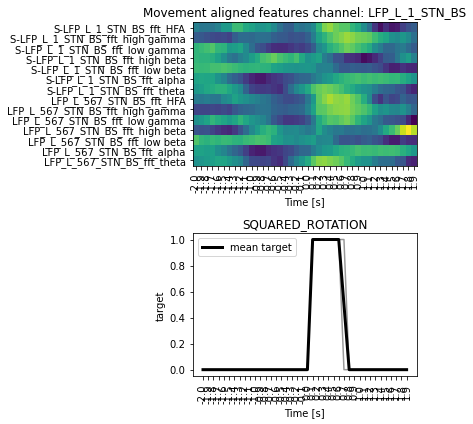

In [6]:
# init analyzer
feature_reader_default = nm_analysis.Feature_Reader(
    feature_dir=PATH_OUT, feature_file=RUN_NAME
)

# plot for a single channel
ch_used = feature_reader_default.nm_channels.query(
    '(type=="seeg") and (used == 1)'
).iloc[0]["name"]

feature_used_default = (
    "stft" if feature_reader_default.settings["features"]["stft"] else "fft"
)

feature_reader_default.plot_target_averaged_channel(
    ch=ch_used,
    list_feature_keywords=[feature_used_default],
    epoch_len=4,   # Length of epoch in seconds
    threshold=0.5, # Threshold to be used for identifying events
)

Correlation matrix figure saved to /home/lauraflyra/Documents/BCCN/Lab_Rotation_DBS_Decoding/Code/py_neuromodulation/examples/data/derivatives/rereferencing/default/rereferencing_example_LFP_default.png


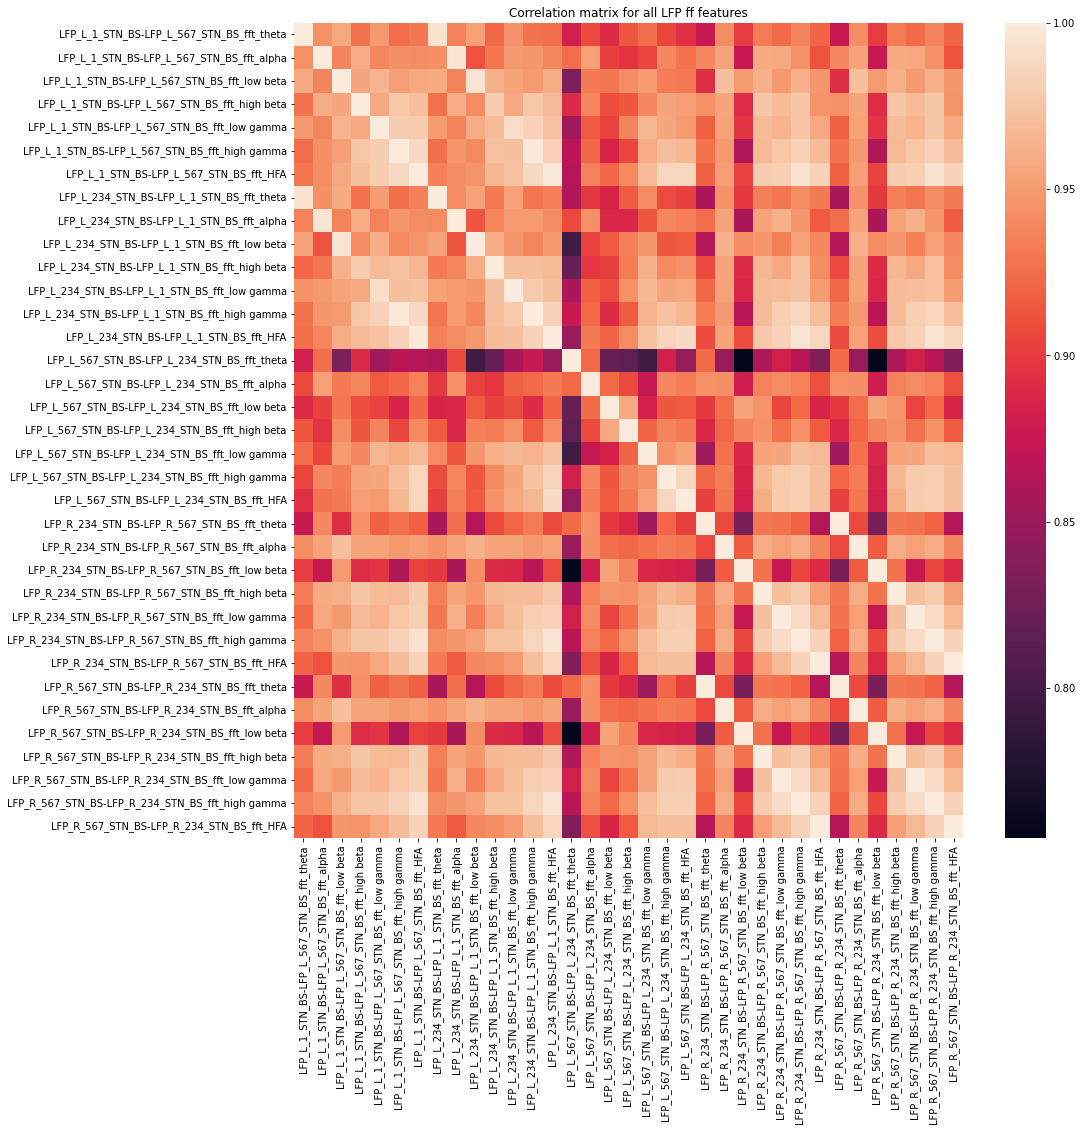

In [7]:
nm_plots.plot_corr_matrix(
        feature = feature_reader_default.feature_arr.filter(regex='LFP'),
        OUT_PATH= PATH_OUT,
        feature_names=feature_reader_default.feature_arr.filter(regex='LFP').columns,
        feature_file=feature_reader_default.feature_file,
        show_plot=True,
        figsize=(15,15),
        title = "Correlation matrix for all LFP ff features",
        save_plot_name="rereferencing_example_LFP_default.png"
)

In [8]:
feature_reader_default.feature_arr.T

,0,1,2,3,4,5,6,7,8,9,...,160,161,162,163,164,165,166,167,168,169
LFP_L_1_STN_BS-LFP_L_567_STN_BS_fft_theta,2.385907,1.0,1.012056,0.857552,0.589625,0.241773,-0.056653,-0.166181,0.049515,0.676085,...,0.190752,0.175194,0.200651,0.284589,0.333105,0.386924,0.425231,0.449930,0.448223,0.420095
LFP_L_1_STN_BS-LFP_L_567_STN_BS_fft_alpha,2.109903,1.0,0.974309,0.806859,0.528674,0.234519,-0.030996,-0.124332,0.145014,0.807374,...,0.312293,0.362528,0.424169,0.470417,0.492336,0.516614,0.531771,0.527160,0.485027,0.332800
LFP_L_1_STN_BS-LFP_L_567_STN_BS_fft_low beta,1.996584,1.0,0.996864,0.856156,0.591048,0.288859,0.003285,-0.097108,0.185362,0.859537,...,0.200668,0.212289,0.257557,0.279788,0.268606,0.232945,0.224488,0.216040,0.206583,0.231646
LFP_L_1_STN_BS-LFP_L_567_STN_BS_fft_high beta,1.869730,1.0,1.011387,0.838162,0.586779,0.302688,0.034424,-0.044891,0.154437,0.719342,...,0.458064,0.437903,0.419810,0.444844,0.382945,0.376899,0.348885,0.336836,0.277808,0.218279
LFP_L_1_STN_BS-LFP_L_567_STN_BS_fft_low gamma,1.558427,1.0,1.042205,0.913379,0.692986,0.437832,0.209422,0.152000,0.353178,0.870160,...,0.101932,0.104293,0.098017,0.130543,0.105408,0.086712,0.057394,0.014510,-0.037011,-0.055827
LFP_L_1_STN_BS-LFP_L_567_STN_BS_fft_high gamma,1.439739,1.0,1.019174,0.891152,0.690051,0.470863,0.280896,0.233979,0.437921,0.917110,...,0.293147,0.275010,0.238781,0.239707,0.196035,0.161791,0.111966,0.078058,0.059602,0.057814
LFP_L_1_STN_BS-LFP_L_567_STN_BS_fft_HFA,1.266451,1.0,1.032428,0.914553,0.742900,0.560320,0.406138,0.396901,0.624915,1.076563,...,0.326175,0.345168,0.339191,0.374542,0.340877,0.316449,0.283161,0.253483,0.220547,0.185720
LFP_L_234_STN_BS-LFP_L_1_STN_BS_fft_theta,2.364687,1.0,1.003815,0.844487,0.580512,0.246697,-0.039389,-0.131988,0.110757,0.771919,...,0.059664,0.031430,0.107110,0.200129,0.273456,0.335542,0.384105,0.418039,0.414299,0.401555
LFP_L_234_STN_BS-LFP_L_1_STN_BS_fft_alpha,2.105249,1.0,0.981194,0.821818,0.540587,0.238301,-0.035404,-0.139254,0.102636,0.733270,...,0.210527,0.254098,0.306209,0.353172,0.394452,0.421609,0.447670,0.453322,0.425564,0.324069
LFP_L_234_STN_BS-LFP_L_1_STN_BS_fft_low beta,2.041423,1.0,0.996585,0.838583,0.568908,0.247363,-0.062821,-0.149493,0.116004,0.782889,...,0.088004,0.071131,0.099348,0.116438,0.108268,0.089491,0.113916,0.127948,0.165320,0.225990


## Use common averaging re-reference
As we want to re-reference all LFP channels, but no re-referencing for the rest, we do:

In [9]:
PATH_OUT_avg = os.path.join(SCRIPT_DIR, "data", "derivatives", "rereferencing", "avg")
ch_names = raw.ch_names
ref = ["average" if "LFP" in item else "None" for item in ch_names]

We need to define the `nm_channels` again and then `stream.run`.

In [10]:
nm_channels_avg = nm_define_nmchannels.set_channels(
    ch_names=raw.ch_names,
    ch_types=raw.get_channel_types(),
    reference=ref,
    bads=raw.info["bads"],
    new_names="default",
    used_types=("seeg","dbs"),  # We focus only on LFP data
    target_keywords=("SQUARED_ROTATION",),
)
nm_channels_avg

,name,rereference,used,target,type,status,new_name
0,ANALOG_R_ROTA_CH,None,0,0,misc,good,ANALOG_R_ROTA_CH
1,ECOG_L_1_SMC_AT,None,0,0,ecog,good,ECOG_L_1_SMC_AT
2,ECOG_L_2_SMC_AT,None,0,0,ecog,good,ECOG_L_2_SMC_AT
3,ECOG_L_3_SMC_AT,None,0,0,ecog,good,ECOG_L_3_SMC_AT
4,ECOG_L_4_SMC_AT,None,0,0,ecog,good,ECOG_L_4_SMC_AT
5,ECOG_L_5_SMC_AT,None,0,0,ecog,good,ECOG_L_5_SMC_AT
6,ECOG_L_6_SMC_AT,None,0,0,ecog,good,ECOG_L_6_SMC_AT
7,EEG_AO,None,0,0,misc,good,EEG_AO
8,LFP_L_1_STN_BS,average,1,0,seeg,good,LFP_L_1_STN_BS-avgref
9,LFP_L_234_STN_BS,average,1,0,seeg,good,LFP_L_234_STN_BS-avgref


In [11]:
stream_avg = nm.Stream(
    settings=None,
    nm_channels=nm_channels_avg,
    path_grids=None,
    verbose=False,
)

stream_avg.set_settings_fast_compute()

stream_avg.init_stream(
    sfreq=sfreq,
    line_noise=line_noise,
    coord_list=coord_list,
    coord_names=coord_names,
)

stream_avg.run(
    data=data,
    out_path_root=PATH_OUT_avg,
    folder_name=RUN_NAME,
)

No Error occurred when testing the settings.
No data specified. Sanity checks related to the length of the signal relative to the filter order will be skipped.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 7.50 Hz
- Upper transition bandwidth: 7.50 Hz
- Filter length: 999 samples (0.999 sec)

_SIDECAR.json saved to /home/lauraflyra/Documents/BCCN/Lab_Rotation_DBS_Decoding/Code/py_neuromodulation/examples/data/derivatives/rereferencing/avg/sub-testsub_ses-EphysMedOff_task-buttonpress_run-0/sub-testsub_ses-EphysMedOff_task-buttonpress_run-0_SIDECAR.json
FEATURES.csv saved to /home/lauraflyra/Documents/BCCN/Lab_Rotation_DBS_Decoding/Code/py_neuromodulation/examples/data/derivatives/rereferencing/avg/sub-testsub_ses-EphysMedOff_task-buttonpress_run-0/su

Feature epoch average figure saved to: /home/lauraflyra/Documents/BCCN/Lab_Rotation_DBS_Decoding/Code/py_neuromodulation/examples/data/derivatives/rereferencing/avg/sub-testsub_ses-EphysMedOff_task-buttonpress_run-0/MOV_aligned_features_ch_LFP_L_1_STN_BS_fft.png


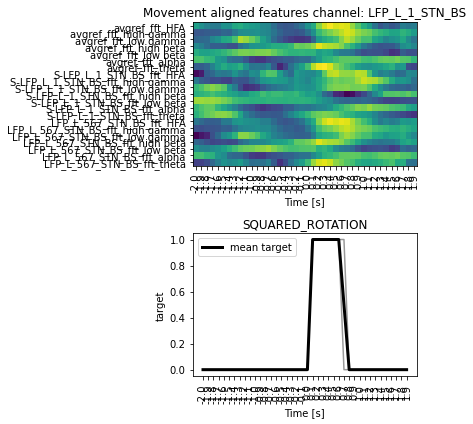

In [12]:
# init analyzer
feature_reader_avg = nm_analysis.Feature_Reader(
    feature_dir=PATH_OUT_avg, feature_file=RUN_NAME
)

# plot for a single channel
ch_used_avg = feature_reader_avg.nm_channels.query(
    '(type=="seeg") and (used == 1)'
).iloc[0]["name"]

feature_used_avg = (
    "stft" if feature_reader_avg.settings["features"]["stft"] else "fft"
)

feature_reader_avg.plot_target_averaged_channel(
    ch=ch_used_avg,
    list_feature_keywords=[feature_used_avg],
    epoch_len=4,   # Length of epoch in seconds
    threshold=0.5, # Threshold to be used for identifying events
)

Correlation matrix figure saved to /home/lauraflyra/Documents/BCCN/Lab_Rotation_DBS_Decoding/Code/py_neuromodulation/examples/data/derivatives/rereferencing/avg/rereferencing_example_LFP_avgref.png


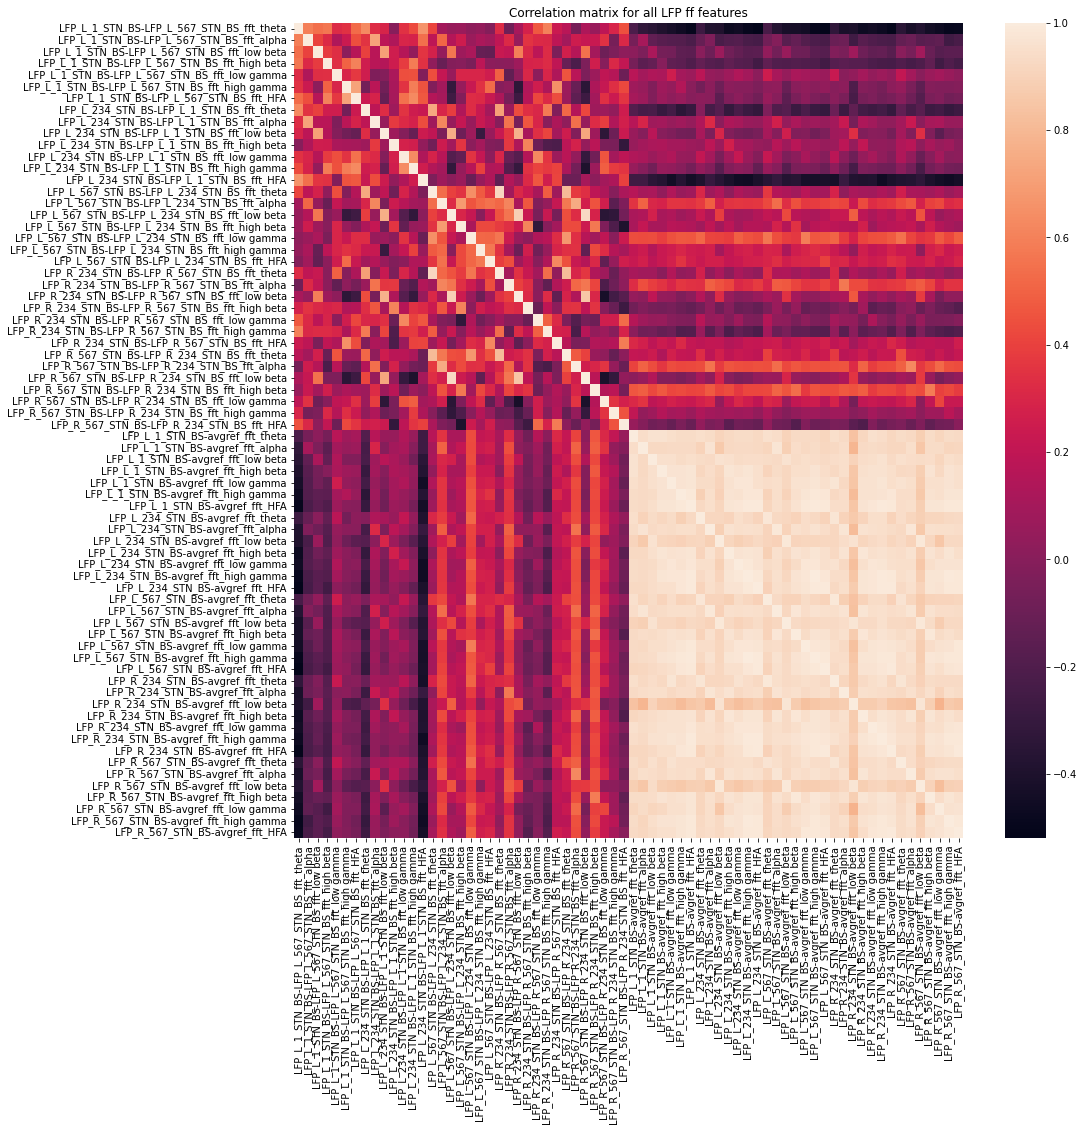

In [13]:
nm_plots.plot_corr_matrix(
        feature = feature_reader_avg.feature_arr.filter(regex='LFP'),
        OUT_PATH= PATH_OUT_avg,
        feature_names=feature_reader_avg.feature_arr.filter(regex='LFP').columns,
        feature_file=feature_reader_avg.feature_file,
        show_plot=True,
        figsize=(15,15),
        title = "Correlation matrix for all LFP ff features",
        save_plot_name="rereferencing_example_LFP_avgref.png"
)

In [14]:
feature_reader_avg.feature_arr.T

,0,1,2,3,4,5,6,7,8,9,...,160,161,162,163,164,165,166,167,168,169
LFP_L_1_STN_BS-LFP_L_567_STN_BS_fft_theta,7.575487,-1.0,-1.112549,-1.428225,-1.462230,-1.696702,-1.643847,-1.657765,-1.700625,-1.623467,...,-0.226072,-0.590979,-0.470088,-0.186893,0.048380,0.239775,0.430680,0.535995,0.454517,0.461837
LFP_L_1_STN_BS-LFP_L_567_STN_BS_fft_alpha,6.975530,-1.0,-1.382344,-1.364494,-1.421002,-1.379729,-1.290692,-1.279116,-1.209602,-1.310114,...,0.517100,0.577473,0.645189,0.723328,0.841021,0.901326,0.917714,0.861435,0.710453,-0.023579
LFP_L_1_STN_BS-LFP_L_567_STN_BS_fft_low beta,6.501623,1.0,-1.413145,-1.558728,-1.785281,-1.731249,-1.663633,-1.429009,-1.111548,-1.083892,...,-0.595374,-0.765047,-0.789815,-0.774283,-0.828888,-0.778506,-0.685644,-0.653422,-0.670524,-0.561450
LFP_L_1_STN_BS-LFP_L_567_STN_BS_fft_high beta,5.908508,-1.0,0.343350,-1.647772,-1.610218,-1.432794,-1.597905,-1.556810,-1.688882,-1.884055,...,-0.408430,-0.811297,-1.238568,-1.219178,-1.485443,-1.704179,-1.906376,-1.785525,-1.968574,-2.096556
LFP_L_1_STN_BS-LFP_L_567_STN_BS_fft_low gamma,4.830047,-1.0,1.411948,1.445540,1.074785,0.157780,-1.520941,-1.753145,-1.747745,-1.646318,...,-0.227613,-0.289649,-0.400707,-0.438683,-0.356186,-0.224715,-0.242162,-0.380138,-0.669942,-0.680397
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LFP_R_567_STN_BS-avgref_fft_low gamma,1.299091,1.0,1.024776,0.925750,0.760611,0.586066,0.471315,0.493228,0.756316,1.220054,...,0.188120,0.175207,0.202365,0.219981,0.191692,0.180230,0.158743,0.153637,0.185378,0.175808
LFP_R_567_STN_BS-avgref_fft_high gamma,1.300758,1.0,1.031773,0.925706,0.736899,0.533783,0.371395,0.345234,0.531951,0.989178,...,0.111386,0.101583,0.135650,0.154631,0.150979,0.176146,0.164308,0.164409,0.185416,0.179062
LFP_R_567_STN_BS-avgref_fft_HFA,1.144806,1.0,1.032479,0.949952,0.788967,0.612010,0.487958,0.487553,0.687269,1.097126,...,0.129278,0.131328,0.151415,0.159275,0.152050,0.172603,0.169497,0.166705,0.190588,0.190250
time,1000.000000,1100.0,1200.000000,1300.000000,1400.000000,1500.000000,1600.000000,1700.000000,1800.000000,1900.000000,...,17000.000000,17100.000000,17200.000000,17300.000000,17400.000000,17500.000000,17600.000000,17700.000000,17800.000000,17900.000000


## No re-referencing

In [15]:
PATH_OUT_None = os.path.join(SCRIPT_DIR, "data", "derivatives", "rereferencing", "none")
ch_names = raw.ch_names
ref_None = ["None" if "LFP" in item else "None" for item in ch_names]

We need to define the `nm_channels` again and then `stream.run`.

In [16]:
nm_channels_None = nm_define_nmchannels.set_channels(
    ch_names=raw.ch_names,
    ch_types=raw.get_channel_types(),
    reference=ref_None,
    bads=raw.info["bads"],
    new_names="default",
    used_types=("seeg","dbs"),  # We focus only on LFP data
    target_keywords=("SQUARED_ROTATION",),
)
nm_channels_None

,name,rereference,used,target,type,status,new_name
0,ANALOG_R_ROTA_CH,None,0,0,misc,good,ANALOG_R_ROTA_CH
1,ECOG_L_1_SMC_AT,None,0,0,ecog,good,ECOG_L_1_SMC_AT
2,ECOG_L_2_SMC_AT,None,0,0,ecog,good,ECOG_L_2_SMC_AT
3,ECOG_L_3_SMC_AT,None,0,0,ecog,good,ECOG_L_3_SMC_AT
4,ECOG_L_4_SMC_AT,None,0,0,ecog,good,ECOG_L_4_SMC_AT
5,ECOG_L_5_SMC_AT,None,0,0,ecog,good,ECOG_L_5_SMC_AT
6,ECOG_L_6_SMC_AT,None,0,0,ecog,good,ECOG_L_6_SMC_AT
7,EEG_AO,None,0,0,misc,good,EEG_AO
8,LFP_L_1_STN_BS,None,1,0,seeg,good,LFP_L_1_STN_BS
9,LFP_L_234_STN_BS,None,1,0,seeg,good,LFP_L_234_STN_BS


In [17]:
stream_None = nm.Stream(
    settings=None,
    nm_channels=nm_channels_None,
    path_grids=None,
    verbose=False,
)

stream_None.set_settings_fast_compute()

stream_None.init_stream(
    sfreq=sfreq,
    line_noise=line_noise,
    coord_list=coord_list,
    coord_names=coord_names,
)

stream_None.run(
    data=data,
    out_path_root=PATH_OUT_None,
    folder_name=RUN_NAME,
)

No Error occurred when testing the settings.
No data specified. Sanity checks related to the length of the signal relative to the filter order will be skipped.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 7.50 Hz
- Upper transition bandwidth: 7.50 Hz
- Filter length: 999 samples (0.999 sec)

_SIDECAR.json saved to /home/lauraflyra/Documents/BCCN/Lab_Rotation_DBS_Decoding/Code/py_neuromodulation/examples/data/derivatives/rereferencing/none/sub-testsub_ses-EphysMedOff_task-buttonpress_run-0/sub-testsub_ses-EphysMedOff_task-buttonpress_run-0_SIDECAR.json
FEATURES.csv saved to /home/lauraflyra/Documents/BCCN/Lab_Rotation_DBS_Decoding/Code/py_neuromodulation/examples/data/derivatives/rereferencing/none/sub-testsub_ses-EphysMedOff_task-buttonpress_run-0/

Feature epoch average figure saved to: /home/lauraflyra/Documents/BCCN/Lab_Rotation_DBS_Decoding/Code/py_neuromodulation/examples/data/derivatives/rereferencing/none/sub-testsub_ses-EphysMedOff_task-buttonpress_run-0/MOV_aligned_features_ch_LFP_L_1_STN_BS_fft.png


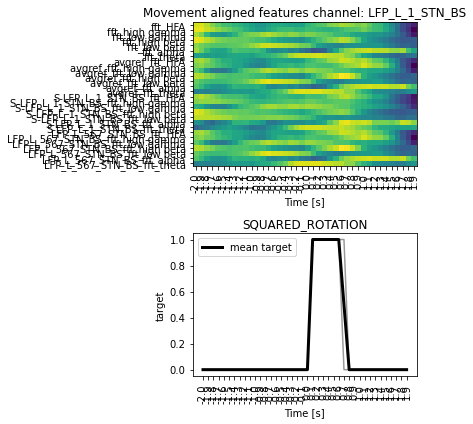

In [18]:
# init analyzer
feature_reader_None = nm_analysis.Feature_Reader(
    feature_dir=PATH_OUT_None, feature_file=RUN_NAME
)

# plot for a single channel
ch_used_None = feature_reader_None.nm_channels.query(
    '(type=="seeg") and (used == 1)'
).iloc[0]["name"]

feature_used_None = (
    "stft" if feature_reader_None.settings["features"]["stft"] else "fft"
)

feature_reader_None.plot_target_averaged_channel(
    ch=ch_used_None,
    list_feature_keywords=[feature_used_None],
    epoch_len=4,   # Length of epoch in seconds
    threshold=0.5, # Threshold to be used for identifying events
)

Correlation matrix figure saved to /home/lauraflyra/Documents/BCCN/Lab_Rotation_DBS_Decoding/Code/py_neuromodulation/examples/data/derivatives/rereferencing/none/rereferencing_example_LFP_None.png


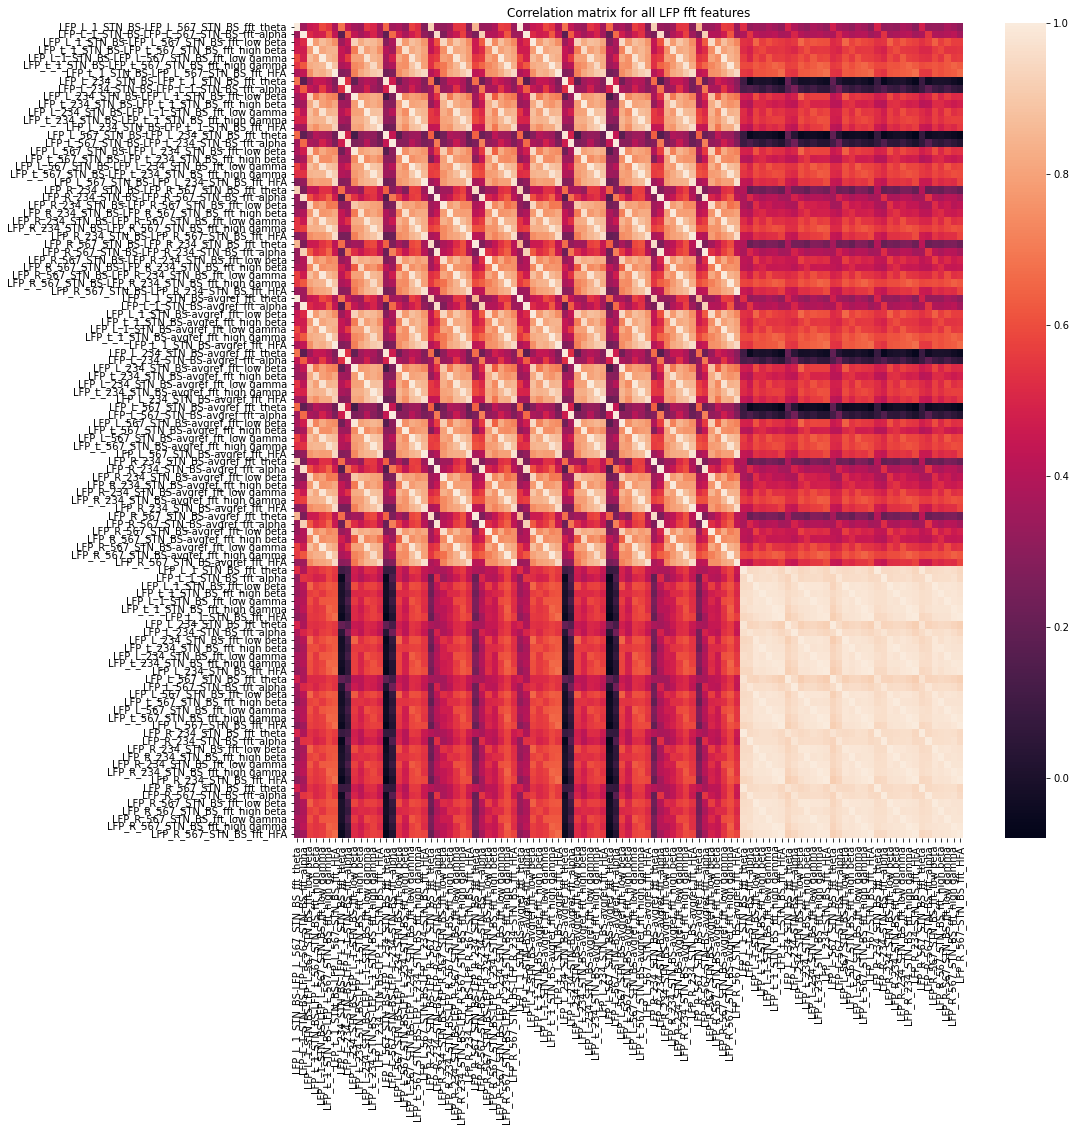

In [19]:
nm_plots.plot_corr_matrix(
        feature = feature_reader_None.feature_arr.filter(regex='LFP'),
        OUT_PATH= PATH_OUT_None,
        feature_names=feature_reader_None.feature_arr.filter(regex='LFP').columns,
        feature_file=feature_reader_None.feature_file,
        show_plot=True,
        figsize=(15,15),
        title = "Correlation matrix for all LFP fft features",
        save_plot_name="rereferencing_example_LFP_None.png"
)

## User provided channels for re-referencing

In [20]:
PATH_OUT_userRef = os.path.join(SCRIPT_DIR, "data", "derivatives", "rereferencing", "userRef")
ref_userRef = ["None","None","None","None","None","None","None","None","LFP_L_2_STN_BS","LFP_L_1_STN_BS","LFP_L_1_STN_BS","LFP_R_1_STN_BS","LFP_R_1_STN_BS","None","None"]

We need to define the `nm_channels` again and then `stream.run`.

In [21]:
nm_channels_userRef = nm_define_nmchannels.set_channels(
    ch_names=raw.ch_names,
    ch_types=raw.get_channel_types(),
    reference=ref_userRef,
    bads=raw.info["bads"],
    new_names="default",
    used_types=("seeg","dbs"),  # We focus only on LFP data
    target_keywords=("SQUARED_ROTATION",),
)
nm_channels_userRef

,name,rereference,used,target,type,status,new_name
0,ANALOG_R_ROTA_CH,None,0,0,misc,good,ANALOG_R_ROTA_CH
1,ECOG_L_1_SMC_AT,None,0,0,ecog,good,ECOG_L_1_SMC_AT
2,ECOG_L_2_SMC_AT,None,0,0,ecog,good,ECOG_L_2_SMC_AT
3,ECOG_L_3_SMC_AT,None,0,0,ecog,good,ECOG_L_3_SMC_AT
4,ECOG_L_4_SMC_AT,None,0,0,ecog,good,ECOG_L_4_SMC_AT
5,ECOG_L_5_SMC_AT,None,0,0,ecog,good,ECOG_L_5_SMC_AT
6,ECOG_L_6_SMC_AT,None,0,0,ecog,good,ECOG_L_6_SMC_AT
7,EEG_AO,None,0,0,misc,good,EEG_AO
8,LFP_L_1_STN_BS,LFP_L_2_STN_BS,1,0,seeg,good,LFP_L_1_STN_BS-LFP_L_2_STN_BS
9,LFP_L_234_STN_BS,LFP_L_1_STN_BS,1,0,seeg,good,LFP_L_234_STN_BS-LFP_L_1_STN_BS


In [22]:
stream_userRef = nm.Stream(
    settings=None,
    nm_channels=nm_channels_None,
    path_grids=None,
    verbose=False,
)

stream_userRef.set_settings_fast_compute()

stream_userRef.init_stream(
    sfreq=sfreq,
    line_noise=line_noise,
    coord_list=coord_list,
    coord_names=coord_names,
)

stream_userRef.run(
    data=data,
    out_path_root=PATH_OUT_userRef,
    folder_name=RUN_NAME,
)

No Error occurred when testing the settings.
No data specified. Sanity checks related to the length of the signal relative to the filter order will be skipped.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 7.50 Hz
- Upper transition bandwidth: 7.50 Hz
- Filter length: 999 samples (0.999 sec)

_SIDECAR.json saved to /home/lauraflyra/Documents/BCCN/Lab_Rotation_DBS_Decoding/Code/py_neuromodulation/examples/data/derivatives/rereferencing/userRef/sub-testsub_ses-EphysMedOff_task-buttonpress_run-0/sub-testsub_ses-EphysMedOff_task-buttonpress_run-0_SIDECAR.json
FEATURES.csv saved to /home/lauraflyra/Documents/BCCN/Lab_Rotation_DBS_Decoding/Code/py_neuromodulation/examples/data/derivatives/rereferencing/userRef/sub-testsub_ses-EphysMedOff_task-buttonpress_

Feature epoch average figure saved to: /home/lauraflyra/Documents/BCCN/Lab_Rotation_DBS_Decoding/Code/py_neuromodulation/examples/data/derivatives/rereferencing/userRef/sub-testsub_ses-EphysMedOff_task-buttonpress_run-0/MOV_aligned_features_ch_LFP_L_1_STN_BS_fft.png


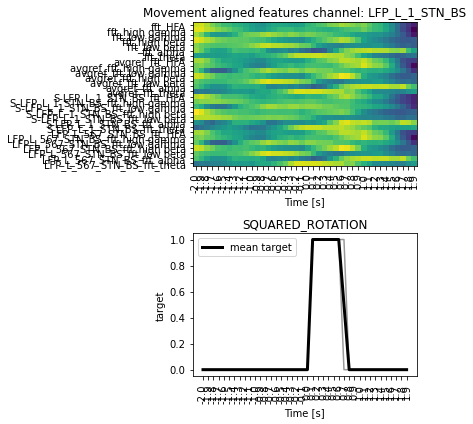

In [23]:
# init analyzer
feature_reader_userRef = nm_analysis.Feature_Reader(
    feature_dir=PATH_OUT_userRef, feature_file=RUN_NAME
)

# plot for a single channel
ch_used_userRef = feature_reader_userRef.nm_channels.query(
    '(type=="seeg") and (used == 1)'
).iloc[0]["name"]

feature_used_userRef = (
    "stft" if feature_reader_userRef.settings["features"]["stft"] else "fft"
)

feature_reader_userRef.plot_target_averaged_channel(
    ch=ch_used_None,
    list_feature_keywords=[feature_used_None],
    epoch_len=4,   # Length of epoch in seconds
    threshold=0.5, # Threshold to be used for identifying events
)

Correlation matrix figure saved to /home/lauraflyra/Documents/BCCN/Lab_Rotation_DBS_Decoding/Code/py_neuromodulation/examples/data/derivatives/rereferencing/userRef/rereferencing_example_LFP_userRef.png


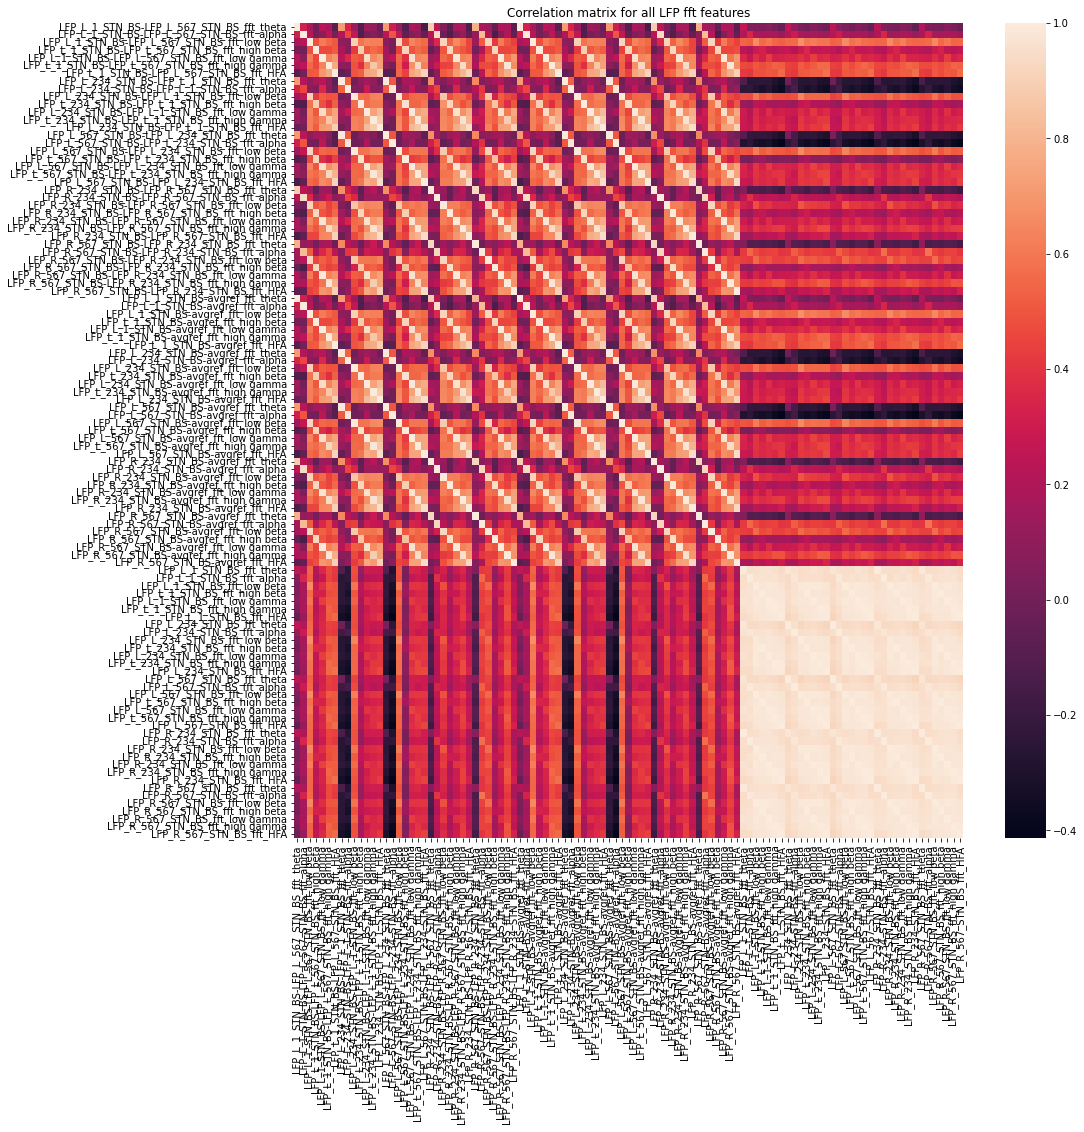

In [24]:
nm_plots.plot_corr_matrix(
        feature = feature_reader_userRef.feature_arr.filter(regex='LFP'),
        OUT_PATH= PATH_OUT_userRef,
        feature_names=feature_reader_userRef.feature_arr.filter(regex='LFP').columns,
        feature_file=feature_reader_userRef.feature_file,
        show_plot=True,
        figsize=(15,15),
        title = "Correlation matrix for all LFP fft features",
        save_plot_name="rereferencing_example_LFP_userRef.png"
)

In [25]:
feature_reader_userRef.feature_arr.T

,0,1,2,3,4,5,6,7,8,9,...,160,161,162,163,164,165,166,167,168,169
LFP_L_1_STN_BS-LFP_L_567_STN_BS_fft_theta,7.930847,-1.0,1.183045,-1.576081,-1.904982,-1.513755,-1.441644,-1.249647,-1.006823,-1.643128,...,-2.338074,-2.223639,-1.955642,-1.655149,-1.135557,-0.776571,-0.440063,-0.085003,0.131410,0.483564
LFP_L_1_STN_BS-LFP_L_567_STN_BS_fft_alpha,7.239139,-1.0,1.409687,1.390757,0.940146,0.226310,-0.366809,-0.815186,-1.074877,-1.888751,...,-1.599238,-1.682500,-1.661517,-1.302808,-1.246294,-1.205875,-1.362250,-1.388996,-1.433952,-1.427605
LFP_L_1_STN_BS-LFP_L_567_STN_BS_fft_low beta,7.211524,1.0,0.720087,-1.603092,-1.705744,-1.204130,-0.704740,0.068960,1.093058,1.805841,...,-1.848969,-1.892572,-1.855624,-1.857954,-1.866758,-2.007633,-1.847887,-1.847258,-1.675862,-1.345550
LFP_L_1_STN_BS-LFP_L_567_STN_BS_fft_high beta,7.248859,-1.0,1.315455,-0.668907,1.088254,-0.937276,-0.121066,2.582561,1.169367,-0.160297,...,-1.652126,-1.658381,-1.395857,-1.016245,-0.810810,-0.796290,-0.626381,-0.229978,0.327972,0.673832
LFP_L_1_STN_BS-LFP_L_567_STN_BS_fft_low gamma,6.230327,1.0,1.196841,1.269762,1.247726,1.231904,1.132447,1.089361,0.882457,0.656636,...,-2.794605,-2.886301,-2.823921,-2.534552,-2.102431,-1.809360,-1.459145,-1.115669,-0.814035,-0.628262
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LFP_R_567_STN_BS_fft_low gamma,1.941775,1.0,1.017792,0.878527,0.641013,0.352874,0.096543,0.007343,0.215404,0.768855,...,-0.088017,-0.115544,-0.135343,-0.118702,-0.070930,-0.033392,0.004070,0.043492,0.078429,0.103141
LFP_R_567_STN_BS_fft_high gamma,1.714305,1.0,1.023138,0.895003,0.678582,0.426990,0.220443,0.199603,0.464160,1.041053,...,-0.014042,-0.041055,-0.041554,-0.042208,-0.031027,-0.021397,-0.013454,0.021003,0.036534,0.067122
LFP_R_567_STN_BS_fft_HFA,1.445434,1.0,1.011424,0.889128,0.687740,0.460792,0.274737,0.282672,0.527053,1.035595,...,0.046134,0.036809,0.039755,0.038761,0.043220,0.057885,0.075628,0.131743,0.137571,0.147152
time,1000.000000,1100.0,1200.000000,1300.000000,1400.000000,1500.000000,1600.000000,1700.000000,1800.000000,1900.000000,...,17000.000000,17100.000000,17200.000000,17300.000000,17400.000000,17500.000000,17600.000000,17700.000000,17800.000000,17900.000000
